In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from problems import create_3SAT_H_and_psi
import methods
from annealer import *

# Readme

This notebook contains demonstrations of how the code works. The full python file that was used to produce all the data for the publication (see https://github.com/condensedAI/quantumzero) is `run-simulation.py`.

The notebook first shows how to use this code for a single 3-SAT instance, and solves it using a linear schedule. The rest is then dedicated to running for multiple instances and with BFGS and MCTS included. The `run-simulation.py` file also points out how to use digital annealers, and includes QAOA optimization.

## Creating a 3SAT instance in Hamiltonian form

In [2]:
num_qubits = 7

# Load the instances
instances = np.loadtxt("dataset/sat%s.txt"%num_qubits).astype(np.int_)

# Pick the first instance just for demonstrations
H_initial, H_final, psi_initial, psi_final = create_3SAT_H_and_psi(num_qubits,instances[0])

## Linear solver demo

In [3]:
# Solve using the Linear Method
Ts = np.linspace(20, 500, 30)
num_time_steps = 10.0

fidelities = []
energies = []
for T in tqdm(Ts):
    energy, fidelity = methods.linear(5, T, num_time_steps, H_initial, H_final, psi_initial, psi_final)
    energies.append(energy[-1])
    fidelities.append(fidelity[-1])

100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Text(0, 0.5, 'energy')

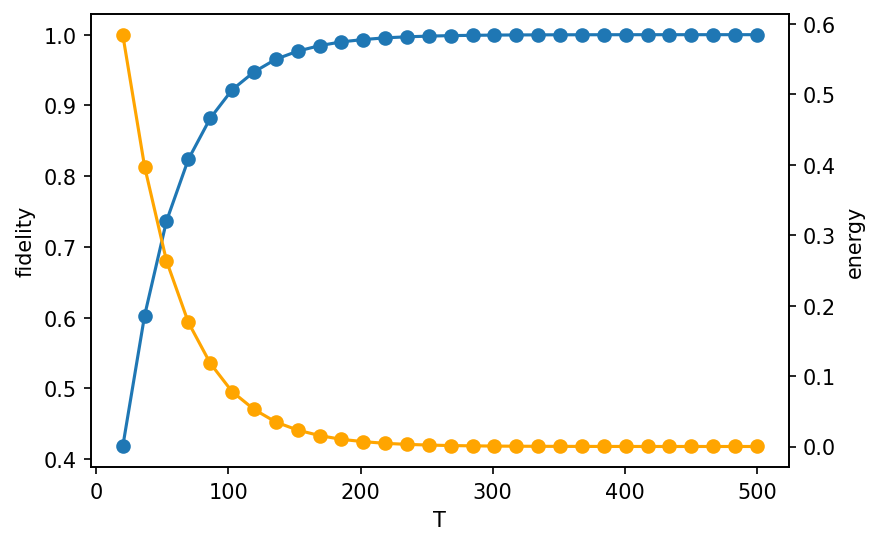

In [4]:
fig, ax = plt.subplots(dpi=150)
ax.plot(Ts, np.array(fidelities), '-o')

ax.set_xlabel("T")
ax.set_ylabel("fidelity")

ax2 = ax.twinx()
ax2.plot(Ts, energies, '-o', c='orange')
ax2.set_ylabel("energy")

## Solving 3-SAT with different methods

For demonstration purposes, we're sticking with 7-qubit instances of 3-SAT problems and optimization of the frequency components. 
For other options, see the `run-simulation.py` file

In [5]:
n_qubit = 7          # Number of qubits
Mcut = 5             # Number of frequency components
T = 10               # Total annealing time
Nt = 3               # Number of steps into which T is divided (and at which times the time-evolution is simulated)
n_candidates = 10    # Number of simulations for MCTS

dt = T/Nt
time_vec = np.linspace(0, T, Nt+1)

filename='dataset/sat'+str(n_qubit)+'.txt'
dataset = np.loadtxt(filename).astype(np.int_)
n_instances = dataset.shape[0]

# For demonstration purposes only, just use 3 instances (only 1 available for larger n_qubit!)
n_instances = 3

## Optimize

In [6]:
best_result = {'bfgs':[], 'mcts':[], 'lin':[]}
best_path = {'bfgs':[], 'mcts':[]}
tevo = {'bfgs':[], 'mcts':[], 'lin':[]}

bzero = np.zeros(Mcut) 

# Fix optimization space here. For more options, see run-simlation.py
optimization_space = 'frequency'
# Fix the optimization of fidelity. For more options, see run-simulation.py
cost_function = 'fidelity'
# Fix annealing type. For more options, see run-simulation.py
annealing_type = 'analog'

for instance in tqdm(range(n_instances)):
    result = dataset[instance,:]
    H0,Hf,psi0,psif=create_3SAT_H_and_psi(n_qubit,result)
    
    # Use analog annealing; see run-simulation.py for the digital version
    pathdesign = AnalogAnnealer(dt, T, H0, Hf, psi0, psif)

    # BFGS; Turn on verbose for convergence output
    print("Running BFGS for instance %d"%instance)
    obs_bfgs, fid_bfgs, nfev_bfgs = methods.gradient_descent(n_qubit, T, Mcut, Nt, H0, Hf, psi0, psif, n_candidates, cost_function_type=cost_function,
                                    optimization_space=optimization_space, noise=0.1, verbose=False)

    # MCTS
    print("Running MCTS for instance %d"%instance)
    obs_mcts, fid_mcts, nfev_mcts = methods.mcts(n_qubit,T, Mcut , Nt, H0,Hf,psi0,psif,n_candidates,cost_function_type=cost_function,
                                annealing_type=annealing_type, optimization_space=optimization_space)
    obs_mcts=obs_mcts.reshape(-1)
    
    # Get energy and fidelity
    en_bfgs, fid_bfgs = pathdesign.anneal(obs_bfgs)
    en_mcts, fid_mcts = pathdesign.anneal(obs_mcts)    

    # Linear schedule comparison
    en_lin, fid_lin = pathdesign.anneal(bzero)

    # print(f'energy={en[-1]}, fidelity={fid[-1]}, improvement over linear={fid[-1]/fid_lin[-1]}\n')
    # print(f'optimal F components={obs}\n')
    
    best_result['bfgs'].append([instance, fid_bfgs[-1], en_bfgs[-1], nfev_bfgs])
    best_path['bfgs'].append(obs_bfgs)    
    best_result['mcts'].append([instance, fid_mcts[-1], en_mcts[-1], nfev_mcts])
    best_path['mcts'].append(obs_mcts)    
    best_result['lin'].append([instance, fid_lin[-1], en_lin[-1]])    

    tevo['lin'].append(np.concatenate( (time_vec.reshape([Nt+1,1]), np.array(fid_lin).reshape([Nt+1,1]), np.array(en_lin).reshape([Nt+1,1])), axis=1) )
    tevo['bfgs'].append(np.concatenate( (time_vec.reshape([Nt+1,1]), np.array(fid_bfgs).reshape([Nt+1,1]), np.array(en_bfgs).reshape([Nt+1,1])), axis=1) )
    tevo['mcts'].append(np.concatenate( (time_vec.reshape([Nt+1,1]), np.array(fid_mcts).reshape([Nt+1,1]), np.array(en_mcts).reshape([Nt+1,1])), axis=1) )    
    
# Reshape final results
tevo['lin']  = np.array(tevo['lin']).reshape([(Nt+1)*n_instances,3])
tevo['bfgs'] = np.array(tevo['bfgs']).reshape([(Nt+1)*n_instances,3])
tevo['mcts'] = np.array(tevo['mcts']).reshape([(Nt+1)*n_instances,3])

  0%|          | 0/3 [00:00<?, ?it/s]

Running BFGS for instance 0
Running MCTS for instance 0


 33%|███▎      | 1/3 [00:10<00:21, 10.60s/it]

Num rounds:  51
Running BFGS for instance 1
Running MCTS for instance 1


 67%|██████▋   | 2/3 [00:25<00:13, 13.23s/it]

Num rounds:  51
Running BFGS for instance 2
Running MCTS for instance 2


100%|██████████| 3/3 [00:36<00:00, 12.08s/it]

Num rounds:  51


### Plot the resulting annealing paths

In [10]:
time_vec = np.linspace(0, T, Nt+1)

def get_path(obs):
    results = []
    for t in time_vec:
        st=t/T
        for i in range(Mcut):
            st = st + obs[i] * math.sin(i*np.pi*st)
        results.append(st)
    return results

Text(0, 0.5, '$s(t)$')

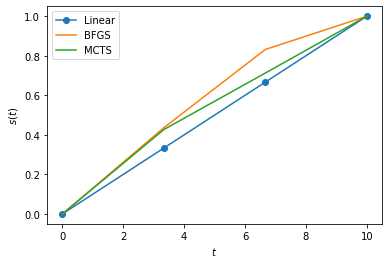

In [11]:
fig, ax = plt.subplots()

ax.plot(time_vec, time_vec/time_vec[-1], '-o', label='Linear')
ax.plot(time_vec, get_path(best_path['bfgs'][0]), label='BFGS')
ax.plot(time_vec, get_path(best_path['mcts'][0]), label='MCTS')
ax.legend(fancybox=True)

ax.set_xlabel("$t$")
ax.set_ylabel("$s(t)$")

### Plot some of the underlying time evolutions

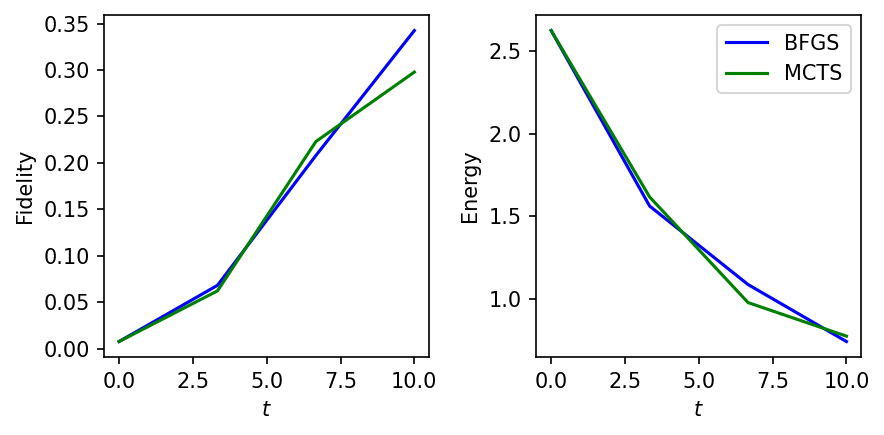

In [12]:
fig, ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

for n in range(n_instances)[:1]:
    bfgs_fidelity = tevo['bfgs'][n*len(time_vec):(n+1)*len(time_vec)][:,1]
    ax[0].plot(time_vec, bfgs_fidelity, c='blue')
    
    mcts_fidelity = tevo['mcts'][n*len(time_vec):(n+1)*len(time_vec)][:,1]
    ax[0].plot(time_vec, mcts_fidelity, c='green')
    
    bfgs_energy = tevo['bfgs'][n*len(time_vec):(n+1)*len(time_vec)][:,2]
    ax[1].plot(time_vec, bfgs_energy, c='blue', label='BFGS')
    
    mcts_energy = tevo['mcts'][n*len(time_vec):(n+1)*len(time_vec)][:,2]
    ax[1].plot(time_vec, mcts_energy, c='green', label='MCTS')   

ax[0].set_ylabel("Fidelity")
ax[1].set_ylabel("Energy")
ax[0].set_xlabel("$t$")
ax[1].set_xlabel("$t$")
ax[1].legend(fancybox=True)
fig.tight_layout()